In [1]:
#imports
import pandas as pd
import os
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms,models
from torchvision.io import read_image
import torch.nn.functional as F 
from torchvision.utils import make_grid
#from torchvision.ops import stochastic_depth
from torch.optim import lr_scheduler

import timm
from timm.loss import LabelSmoothingCrossEntropy

print(torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


2.1.2
cuda:0


# **Loading the dataset**

In [2]:
path = "/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2"


data = {"imagepath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imagepath"].append(fpath)
        data["labels"].append(folder)
        
    df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])


print("-------------Fetch files into a data frame-----------")
print(df)
print("-------------Path to an image file------------------")
print(df.loc[175]['imagepath']) 
print("-----------Number of images per category--------------")
print(df.labels.value_counts())  

-------------Fetch files into a data frame-----------
                                              imagepath labels  encoded_labels
0     /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Zain              30
1     /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Zain              30
2     /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Zain              30
3     /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Zain              30
4     /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Zain              30
...                                                 ...    ...             ...
6980  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa              13
6981  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa              13
6982  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa              13
6983  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa              13
6984  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa              1

# **Displaying Histogram of the dataset**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


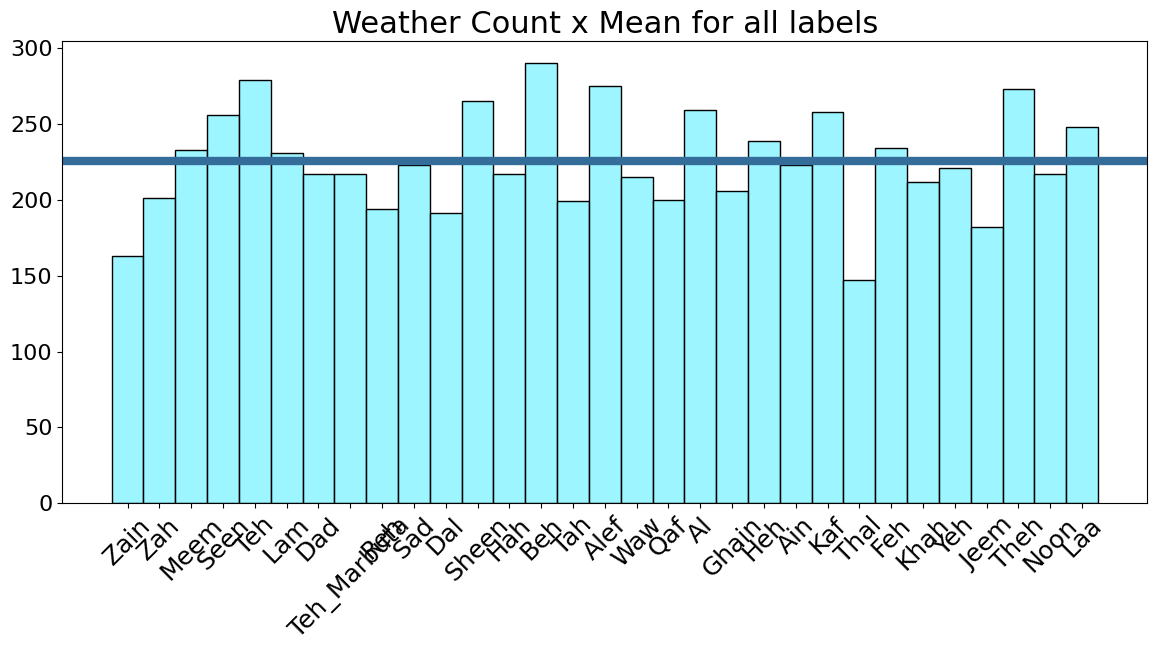

In [3]:
ax = sns.histplot(data=df, x="labels", color="#7df2ff")
ax.figure.set_size_inches(14, 6)
plt.axhline(y=df.groupby("labels").count().mean().mean(), lw=6, color="#346c9a")
plt.xticks(rotation=45, font="Verdana", fontsize=18)
plt.yticks(font="Verdana", fontsize=16)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Weather Count x Mean for all labels", font="Verdana", fontsize=22)

plt.show()

# **Splitting into train,val and test sets** 

In [4]:
train_df, temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124, stratify = df.labels)
valid_df , test_df = train_test_split(temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imagepath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imagepath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imagepath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                           imagepath labels
0  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Ain
1  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Tah
2  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Sad
3  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Jeem
4  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Dad
(4889, 3)
--------Validation----------
                                           imagepath labels
0  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa
1  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Khah
2  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Khah
3  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Seen
4  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Lam
(1467, 3)
----------Test--------------
                                           imagepath labels
0  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...     Al
1  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba... 

# **Displaying random images**

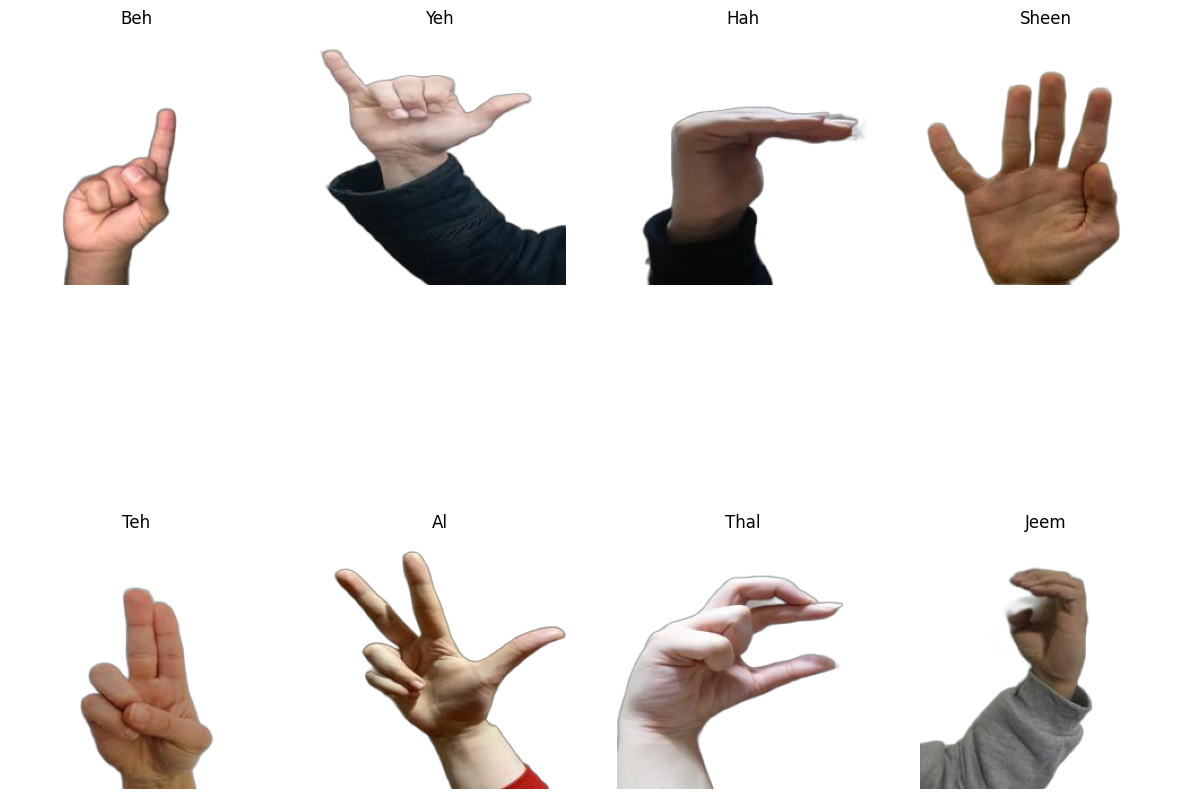

In [5]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=8).reset_index().iterrows():
    plt.subplot(2,4,i+1)
    image_path = row['imagepath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

# **Data Augmentation**

In [6]:

train_transforms = transforms.Compose([
    #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    #transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# **Displaying random sample and the augmented image**

In [7]:
#Load & View Random Sample Image
def load(imagepath, as_tensor=True):
    # Read and decode an image file to a uint8 tensor
    image = Image.open(imagepath).convert('RGB')
    
    if as_tensor:
        converter = transforms.ToTensor()
        return converter(image)
    else:
        return image


def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)
    
    plt.title(f'Label: {label}', fontsize=16)
    return

In [8]:
# Select random sample from df
import random
idx = random.sample(df.index.to_list(), 1)[0]

# Load the random sample and label
aug_image = load(df.imagepath[idx], as_tensor=False)

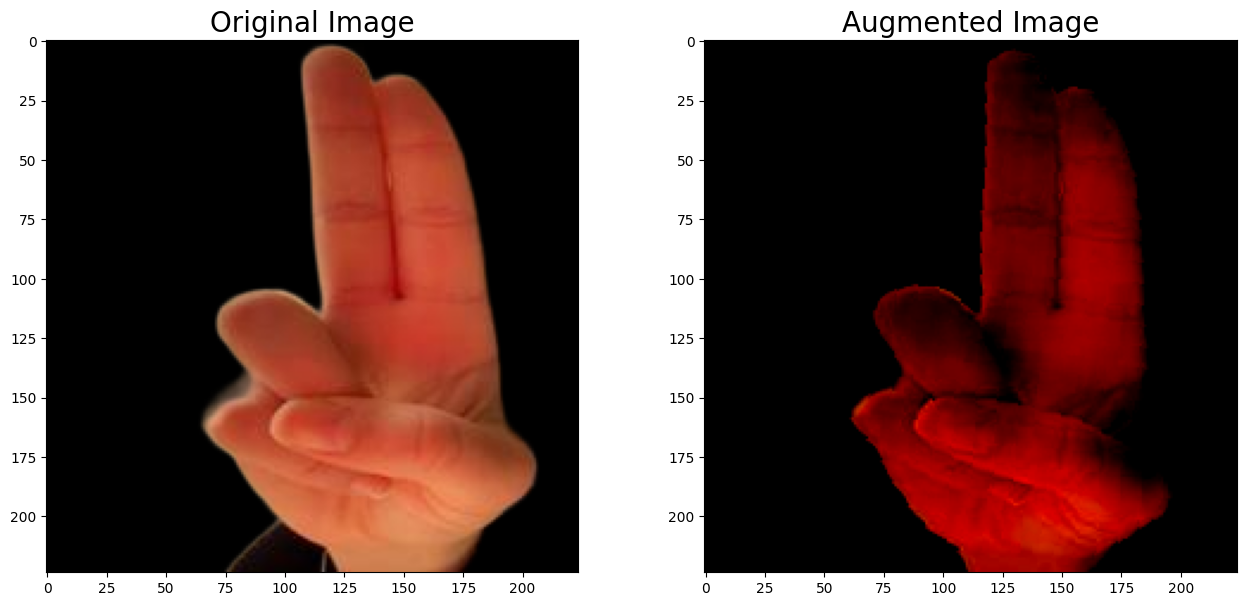

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(aug_image);

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(train_transforms(aug_image).permute(1, 2, 0));

# **Building datasets based on splits**

In [10]:
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

In [11]:
class ArSL_Dataset(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None) -> None:
        super().__init__()
        
        self.paths = df['imagepath'].to_list()
        self.labels = df['labels'].to_list()
        self.transform = transform
        
        self.classes = sorted(list(df['labels'].unique()))
        self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}
        
    def load_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path).convert('RGB')  
        
    def __len__(self) -> int:
        return self.paths.__len__()
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        image = self.load_image(index)
        class_name = self.labels[index]
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(image), class_idx
        else:
            return image, class_idx

In [12]:
# Build train dataset
train_ds = ArSL_Dataset(train_df, transform=train_transforms)

# Build validation dataset
valid_ds = ArSL_Dataset(valid_df, transform=test_transforms)

# Build test dataset
test_ds = ArSL_Dataset(test_df, transform=test_transforms)

In [13]:
BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2 
        else (32 * torch.cuda.device_count())
    )
train_dataloader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size = BATCH_SIZE, shuffle= False)
test_dataloader = DataLoader(test_ds, batch_size= BATCH_SIZE , shuffle=False)

print(">> Number of Train Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(train_dataloader.dataset) , BATCH_SIZE , len(train_dataloader)))
print(">> Number of Valid Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(valid_dataloader.dataset) , BATCH_SIZE , len(valid_dataloader)))
print(">> Number of  Test Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(test_dataloader.dataset) , BATCH_SIZE , len(test_dataloader)))
onebatch = iter(train_dataloader)
train_features, train_labels = next(onebatch)
print("----------Batch Shape--------")
print(f"Feature batch shape: {train_features.size()}")
print("----------Labels Shape--------")
print(f"Labels batch shape: {train_labels.size()}")

>> Number of Train Data : 4889 -- Batch Size : 64 -- Number of Batch : 77 
>> Number of Valid Data : 1467 -- Batch Size : 64 -- Number of Batch : 23 
>> Number of  Test Data : 629 -- Batch Size : 64 -- Number of Batch : 10 
----------Batch Shape--------
Feature batch shape: torch.Size([64, 3, 224, 224])
----------Labels Shape--------
Labels batch shape: torch.Size([64])


In [14]:
#modelr = models.resnet50(pretrained=True)
#for param in modelr.parameters():
    #param.requires_grad = False

#modelr.fc = torch.nn.Linear(modelr.fc.in_features, out_features=31)
#modelr = modelr.to(device)

In [15]:
#modeld = models.densenet161(pretrained=True)
#for param in modeld.parameters():
    #param.requires_grad = False
    
#modeld.classifier = torch.nn.Linear(modeld.classifier.in_features, out_features=31)
#modeld = modeld.to(device)

In [16]:
'''class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        #self.modelC = modelC
        self.classifier = nn.Linear(31 * 2, 31)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        #x3 = self.modelC(x)
        x = torch.cat((x1, x2), dim=1)
        out = self.classifier(x)
        return out
    
model = EnsembleModel(modelr, modeld)

for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True    

model = model.to(device)
'''

'class EnsembleModel(nn.Module):   \n    def __init__(self, modelA, modelB):\n        super().__init__()\n        self.modelA = modelA\n        self.modelB = modelB\n        #self.modelC = modelC\n        self.classifier = nn.Linear(31 * 2, 31)\n        \n    def forward(self, x):\n        x1 = self.modelA(x)\n        x2 = self.modelB(x)\n        #x3 = self.modelC(x)\n        x = torch.cat((x1, x2), dim=1)\n        out = self.classifier(x)\n        return out\n    \nmodel = EnsembleModel(modelr, modeld)\n\nfor param in model.parameters():\n    param.requires_grad = False\n\nfor param in model.classifier.parameters():\n    param.requires_grad = True    \n\nmodel = model.to(device)\n'

# **ResNext50 Architecture**

In [17]:
'''
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, num_group=32):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes*2, stride)
        self.bn1 = nn.BatchNorm2d(planes*2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes*2, planes*2, groups=num_group)
        self.bn2 = nn.BatchNorm2d(planes*2)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, num_group=32):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes*2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes*2)
        self.conv2 = nn.Conv2d(planes*2, planes*2, kernel_size=3, stride=stride,
                               padding=1, bias=False, groups=num_group)
        self.bn2 = nn.BatchNorm2d(planes*2)
        self.conv3 = nn.Conv2d(planes*2, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNeXt(nn.Module):

    def __init__(self, block, layers, num_classes=1000, num_group=32):
        self.inplanes = 64
        super(ResNeXt, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], num_group)
        self.layer2 = self._make_layer(block, 128, layers[1], num_group, stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], num_group, stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], num_group, stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        #self.dropout = nn.Dropout(0.2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, num_group, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, num_group=num_group))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, num_group=num_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        #x = self.dropout(x)
        x = self.fc(x)

        return x


#def resnext18( **kwargs):
    """Constructs a ResNeXt-18 model.
    """
    #model = ResNeXt(BasicBlock, [2, 2, 2, 2], **kwargs)
    #return model


#def resnext34(**kwargs):
    """Constructs a ResNeXt-34 model.
    """
    #model = ResNeXt(BasicBlock, [3, 4, 6, 3], **kwargs)
    #return model


def resnext50(**kwargs):
    """Constructs a ResNeXt-50 model.
    """
    model = ResNeXt(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


#def resnext101(**kwargs):
    """Constructs a ResNeXt-101 model.
    """
    #model = ResNeXt(Bottleneck, [3, 4, 23, 3], **kwargs)
    #return model


#def resnext152(**kwargs):
    """Constructs a ResNeXt-152 model.
    """
    #model = ResNeXt(Bottleneck, [3, 8, 36, 3], **kwargs)
    #return model
'''

'\ndef conv3x3(in_planes, out_planes, stride=1):\n    """3x3 convolution with padding"""\n    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,\n                     padding=1, bias=False)\n\n\nclass BasicBlock(nn.Module):\n    expansion = 1\n\n    def __init__(self, inplanes, planes, stride=1, downsample=None, num_group=32):\n        super(BasicBlock, self).__init__()\n        self.conv1 = conv3x3(inplanes, planes*2, stride)\n        self.bn1 = nn.BatchNorm2d(planes*2)\n        self.relu = nn.ReLU(inplace=True)\n        self.conv2 = conv3x3(planes*2, planes*2, groups=num_group)\n        self.bn2 = nn.BatchNorm2d(planes*2)\n        self.downsample = downsample\n        self.stride = stride\n\n    def forward(self, x):\n        residual = x\n\n        out = self.conv1(x)\n        out = self.bn1(out)\n        out = self.relu(out)\n\n        out = self.conv2(out)\n        out = self.bn2(out)\n\n        if self.downsample is not None:\n            residual = self.downsa

# **KANLinear**

In [18]:
# Define the KANLinear class as provided
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=10, spline_order=3, scale_noise=0.05, scale_base=0.5, scale_spline=0.5, enable_standalone_scale_spline=True, base_activation=nn.SiLU, grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, : -(k + 1)]) / (grid[:, k:-1] - grid[:, : -(k + 1)]) * bases[:, :, :-1]) + ((grid[:, k + 1 :] - x) / (grid[:, k + 1 :] - grid[:, 1:(-k)]) * bases[:, :, 1:])
        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), self.scaled_spline_weight.view(self.out_features, -1))
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)
        splines = self.b_splines(x).permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff).permute(1, 0, 2)
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[torch.linspace(0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device)]
        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (torch.arange(self.grid_size + 1, dtype=torch.float32, device=x.device).unsqueeze(1) * uniform_step + x_sorted[0] - margin)
        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat([grid[:1] - uniform_step * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1), grid, grid[-1:] + uniform_step * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1)], dim=0)
        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy
     

# **Model Architecture**

In [19]:
# Define the model architecture with CustomResNet using KANLinear
class CustomResNetKAN(nn.Module):
    def __init__(self, num_classes=31):
        super(CustomResNetKAN, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = KANLinear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [20]:
#model = resnext50(num_classes = 31)
#model = model.to(device)
model = CustomResNetKAN().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s] 


# **Hyperparameters**

In [21]:
# Define Loss Function
loss_fn = LabelSmoothingCrossEntropy()

# Define Optimizer
optimizer = optim.Adam(model.parameters(),lr= 0.001)


In [22]:
#Define Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# **Train Function**

# 

In [23]:
'''def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into training mode
    model.train()
    
    # Initialize train loss & accuracy
    train_loss, train_acc = 0, 0
    
    # Execute training loop over train dataloader
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Load data onto target device
        X, y = X.to(device), y.to(device)
        
        # Feed-forward and compute metrics
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        
        # Reset Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()
        
        # Update Model Gradients
        optimizer.step()
        
        # Compute Batch Metrics
        predicted_class = torch.argmax(
            torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc
    '''

'def execute_epoch(\n    model:torch.nn.Module,\n    dataloader:torch.utils.data.DataLoader,\n    optimizer:torch.optim.Optimizer,\n    loss_fn:torch.nn.Module,\n    device:torch.device) -> Tuple[float, float]:\n    \n    # Set model into training mode\n    model.train()\n    \n    # Initialize train loss & accuracy\n    train_loss, train_acc = 0, 0\n    \n    # Execute training loop over train dataloader\n    for batch, (X, y) in enumerate(tqdm(dataloader)):\n        # Load data onto target device\n        X, y = X.to(device), y.to(device)\n        \n        # Feed-forward and compute metrics\n        y_pred = model(X)\n        loss = loss_fn(y_pred, y)\n        train_loss += loss.item() \n        \n        # Reset Gradients & Backpropagate Loss\n        optimizer.zero_grad()\n        loss.backward()\n        \n        # Update Model Gradients\n        optimizer.step()\n        \n        # Compute Batch Metrics\n        predicted_class = torch.argmax(\n            torch.softmax(y_pred

In [24]:
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

In [25]:
def execute_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    device: torch.device,
    scaler: GradScaler
) -> Tuple[float, float]:
    # Set model into training mode
    model.train()

    # Initialize train loss & accuracy
    train_loss, train_acc = 0, 0


    # Execute training loop over train dataloader
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Load data onto target device
        X, y = X.to(device), y.to(device)

        # Enable autocast for mixed precision
        with autocast():
            # Forward pass and compute loss
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

        # Reset gradients & backpropagate loss using scaler
        optimizer.zero_grad()
        scaler.scale(loss).backward()

        # Update model gradients using scaler
        scaler.step(optimizer)
        scaler.update()

        # Compute batch metrics
        predicted_class = torch.argmax(
            torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)

    # Compute step metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


# **Evaluation Function**

In [26]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into eval mode
    model.eval()
    
    # Initialize eval loss & accuracy
    eval_loss, eval_acc = 0, 0
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item() 

            # Compute Batch Metrics
            predicted_class = torch.argmax(
                torch.softmax(y_pred, dim=1), dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    
    return eval_loss, eval_acc

In [27]:
'''
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    eval_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
    save_path: str = "best_model.pth"  # Path to save the best model
) -> Dict[str, List]:
    # Initialize training session
    session = {
        'loss': [],
        'accuracy': [],
        'eval_loss': [],
        'eval_accuracy': []
    }
    
    best_eval_acc = 0  # Track the best evaluation accuracy
    
    # Training loop
    for epoch in tqdm(range(epochs)):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        
        # Execute Epoch
        train_loss, train_acc = execute_epoch(
            model, 
            train_dataloader, 
            optimizer, 
            loss_fn, 
            device
        )
        
        # Evaluate Model
        eval_loss, eval_acc = evaluate(
            model, 
            eval_dataloader, 
            loss_fn, 
            device
        )
        
        # Log Epoch Metrics
        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')
        
        # Record Epoch Metrics
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuracy'].append(eval_acc)
        
        # Save the best model
        if eval_acc > best_eval_acc:
            best_eval_acc = eval_acc
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with eval accuracy: {best_eval_acc:.4f}")
        
        # Early stopping condition
        if train_acc >= 0.99 and eval_acc >= 0.98:
            print("Early stopping triggered!")
            break
    
    return session
    '''


'\ndef train(\n    model: torch.nn.Module,\n    train_dataloader: torch.utils.data.DataLoader,\n    eval_dataloader: torch.utils.data.DataLoader,\n    optimizer: torch.optim.Optimizer,\n    loss_fn: torch.nn.Module,\n    epochs: int,\n    device: torch.device,\n    save_path: str = "best_model.pth"  # Path to save the best model\n) -> Dict[str, List]:\n    # Initialize training session\n    session = {\n        \'loss\': [],\n        \'accuracy\': [],\n        \'eval_loss\': [],\n        \'eval_accuracy\': []\n    }\n    \n    best_eval_acc = 0  # Track the best evaluation accuracy\n    \n    # Training loop\n    for epoch in tqdm(range(epochs)):\n        print(f\'\nEpoch {epoch + 1}/{epochs}\')\n        \n        # Execute Epoch\n        train_loss, train_acc = execute_epoch(\n            model, \n            train_dataloader, \n            optimizer, \n            loss_fn, \n            device\n        )\n        \n        # Evaluate Model\n        eval_loss, eval_acc = evaluate(\n  

In [28]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    eval_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
    scheduler: lr_scheduler._LRScheduler,  # Learning rate scheduler
    save_weights_path: str = "best_weights.pth",  # Path to save the best weights
    save_model_path: str = "best_model(ResNet).pth",  # Path to save the best model
    patience: int = 5  # Patience counter for early stopping
) -> Dict[str, List]:
    
    # Initialize training session
    session = {
        'loss': [],
        'accuracy': [],
        'eval_loss': [],
        'eval_accuracy': []
    }
    
    best_eval_acc = 0  # Track the best evaluation accuracy
    patience_counter = 0  # Initialize patience counter
    
    # Initialize GradScaler
    #scaler = GradScaler()
    
    # Training loop
    for epoch in tqdm(range(epochs)):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        
        # Execute Epoch with mixed precision
        train_loss, train_acc = execute_epoch(
            model, 
            train_dataloader, 
            optimizer, 
            loss_fn, 
            device,
            scaler  # Pass GradScaler to execute_epoch
        )
        
        # Evaluate Model
        eval_loss, eval_acc = evaluate(
            model, 
            eval_dataloader, 
            loss_fn, 
            device
        )
        
        # Log Epoch Metrics
        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')
        print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')  # Log the current learning rate
        
        # Record Epoch Metrics
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuracy'].append(eval_acc)
        
        # Save the best weights and model if evaluation accuracy improves
        if eval_acc > best_eval_acc:
            best_eval_acc = eval_acc
            # Save the best weights
            torch.save(model.state_dict(), save_weights_path)
            # Save the best model
            torch.save(model, save_model_path)
            print(f"Best model saved with eval accuracy: {best_eval_acc:.4f}")
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter
        
        # Update the learning rate scheduler
        scheduler.step()
        
        # Early stopping condition based on patience
        if patience_counter >= patience:
            print(f"Early stopping triggered! No improvement for {patience} epochs.")
            break
        
        # Early stopping condition based on high accuracy
        #if train_acc >= 0.99 and eval_acc >= 0.98:
            #print("Early stopping triggered! High accuracy achieved.")
            #break
    
    return session


In [29]:
# Train the model 
print(f'Train on {len(train_df)} samples, validate on {len(valid_df)} samples.')
print('----------------------------------')

session_config = {
    'model'               : model,
    'train_dataloader'    : train_dataloader,
    'eval_dataloader'     : valid_dataloader,
    'optimizer'           : optimizer,
    'loss_fn'             : loss_fn,
    'epochs'              : 50,
    'device'              : device,
    'scheduler'           : scheduler,
}

session_history = train(**session_config)

Train on 4889 samples, validate on 1467 samples.
----------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 1.6868 - acc: 0.6323 - eval_loss: 1.2877 - eval_acc: 0.7899
Learning Rate: 0.001000
Best model saved with eval accuracy: 0.7899

Epoch 2/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 1.1095 - acc: 0.8594 - eval_loss: 0.9919 - eval_acc: 0.9141
Learning Rate: 0.001000
Best model saved with eval accuracy: 0.9141

Epoch 3/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.9583 - acc: 0.9081 - eval_loss: 1.0112 - eval_acc: 0.8867
Learning Rate: 0.001000

Epoch 4/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.9160 - acc: 0.9199 - eval_loss: 1.2674 - eval_acc: 0.7984
Learning Rate: 0.001000

Epoch 5/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.8666 - acc: 0.9341 - eval_loss: 1.0092 - eval_acc: 0.8753
Learning Rate: 0.001000

Epoch 6/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.8370 - acc: 0.9433 - eval_loss: 1.0050 - eval_acc: 0.8827
Learning Rate: 0.001000

Epoch 7/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.7853 - acc: 0.9598 - eval_loss: 0.8686 - eval_acc: 0.9263
Learning Rate: 0.001000
Best model saved with eval accuracy: 0.9263

Epoch 8/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.7192 - acc: 0.9821 - eval_loss: 0.7071 - eval_acc: 0.9836
Learning Rate: 0.000100
Best model saved with eval accuracy: 0.9836

Epoch 9/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6879 - acc: 0.9899 - eval_loss: 0.6988 - eval_acc: 0.9864
Learning Rate: 0.000100
Best model saved with eval accuracy: 0.9864

Epoch 10/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6844 - acc: 0.9921 - eval_loss: 0.6955 - eval_acc: 0.9864
Learning Rate: 0.000100

Epoch 11/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6805 - acc: 0.9932 - eval_loss: 0.6952 - eval_acc: 0.9809
Learning Rate: 0.000100

Epoch 12/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6738 - acc: 0.9953 - eval_loss: 0.6906 - eval_acc: 0.9843
Learning Rate: 0.000100

Epoch 13/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6718 - acc: 0.9951 - eval_loss: 0.6926 - eval_acc: 0.9877
Learning Rate: 0.000100
Best model saved with eval accuracy: 0.9877

Epoch 14/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6693 - acc: 0.9972 - eval_loss: 0.6898 - eval_acc: 0.9870
Learning Rate: 0.000100

Epoch 15/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6667 - acc: 0.9974 - eval_loss: 0.6892 - eval_acc: 0.9863
Learning Rate: 0.000010

Epoch 16/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6661 - acc: 0.9968 - eval_loss: 0.6886 - eval_acc: 0.9870
Learning Rate: 0.000010

Epoch 17/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6673 - acc: 0.9974 - eval_loss: 0.6874 - eval_acc: 0.9863
Learning Rate: 0.000010

Epoch 18/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6653 - acc: 0.9978 - eval_loss: 0.6877 - eval_acc: 0.9863
Learning Rate: 0.000010
Early stopping triggered! No improvement for 5 epochs.


In [30]:
# lr scheduler
#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

# **Inference**

In [31]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    
    # Set model into eval mode
    model.eval()
    
    predictions = []
    
    # Active inference context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X) 

            # Compute Batch Metrics
            predicted_probs = torch.softmax(y_pred, dim=1).cpu().numpy()
            
            # Record prediction
            predictions.append(predicted_probs)
        
    return np.vstack(predictions)

In [32]:
# Generate test sample probabilities 
test_probs = predict(model, test_dataloader, device)

  0%|          | 0/10 [00:00<?, ?it/s]

In [33]:
# Generate test sample preditions 
test_preds = np.argmax(test_probs, axis=1)

# **Plot Model Performance**

In [34]:
def plot_training_curves(history):
    
    loss = np.array(history['loss'])
    val_loss = np.array(history['eval_loss'])

    accuracy = np.array(history['accuracy'])
    val_accuracy = np.array(history['eval_accuracy'])

    epochs = range(len(history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='validation_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();
    
    sns.despine();
    
    return

In [35]:
session_history_df = pd.DataFrame(session_history)
session_history_df

,loss,accuracy,eval_loss,eval_accuracy
0,1.686756,0.632346,1.287717,0.789897
1,1.109492,0.859416,0.991927,0.914057
2,0.958262,0.908052,1.011179,0.886653
3,0.915977,0.919935,1.267371,0.798395
4,0.866618,0.934140,1.009237,0.875276
5,0.837011,0.943271,1.005031,0.882692
6,0.785268,0.959821,0.868636,0.926343
7,0.719222,0.982143,0.707112,0.983638
8,0.687946,0.989943,0.698820,0.986355
9,0.684357,0.992086,0.695477,0.986355


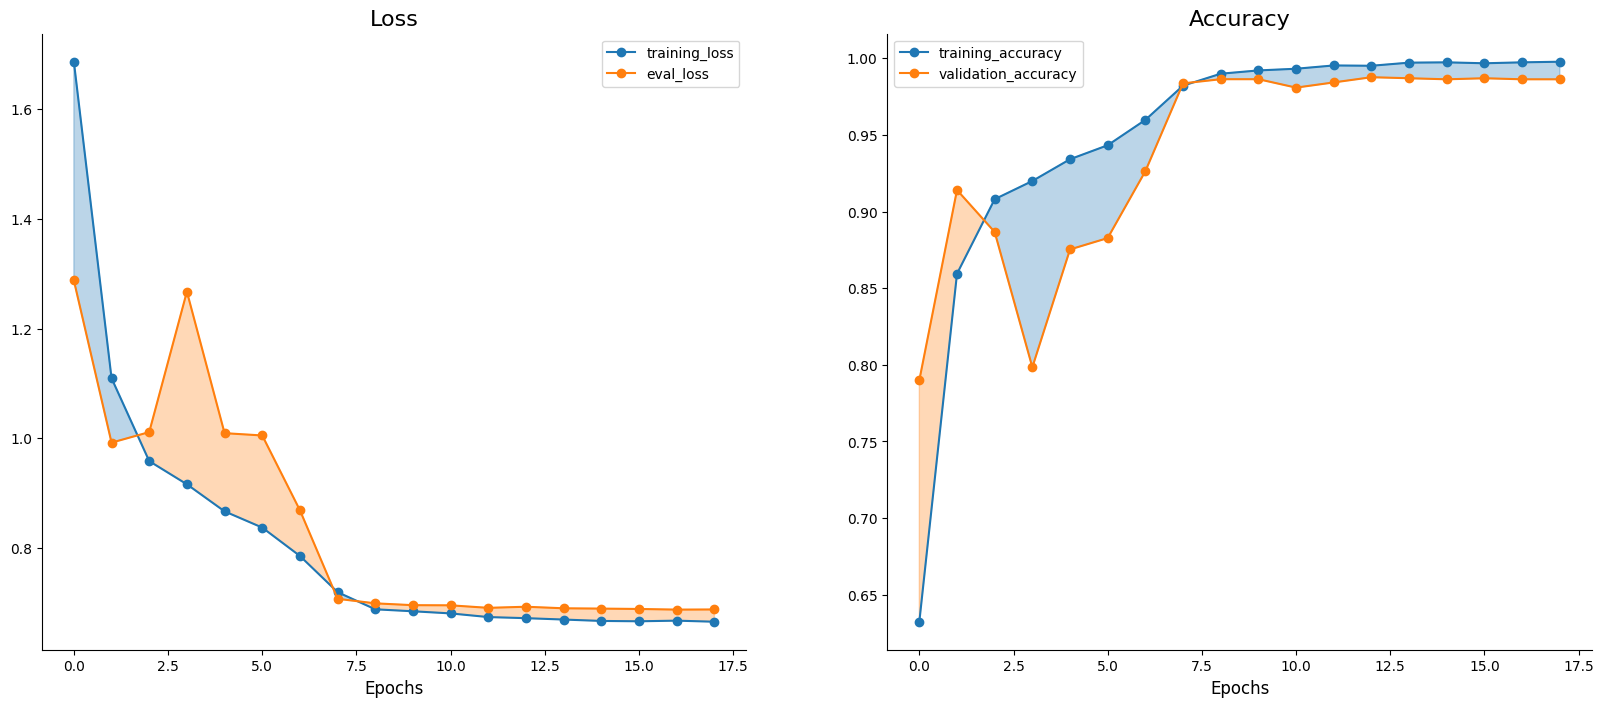

In [36]:
plot_training_curves(session_history)

# **Performance Metrics**

In [37]:
#imports
from scikitplot.metrics import plot_roc
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, top_k_accuracy_score, f1_score, 
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
)

**Confusion Matrix**

In [38]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    
    return

In [39]:
#mapping
test_labels = [*map(test_ds.class_to_idx.get, test_ds.labels)]

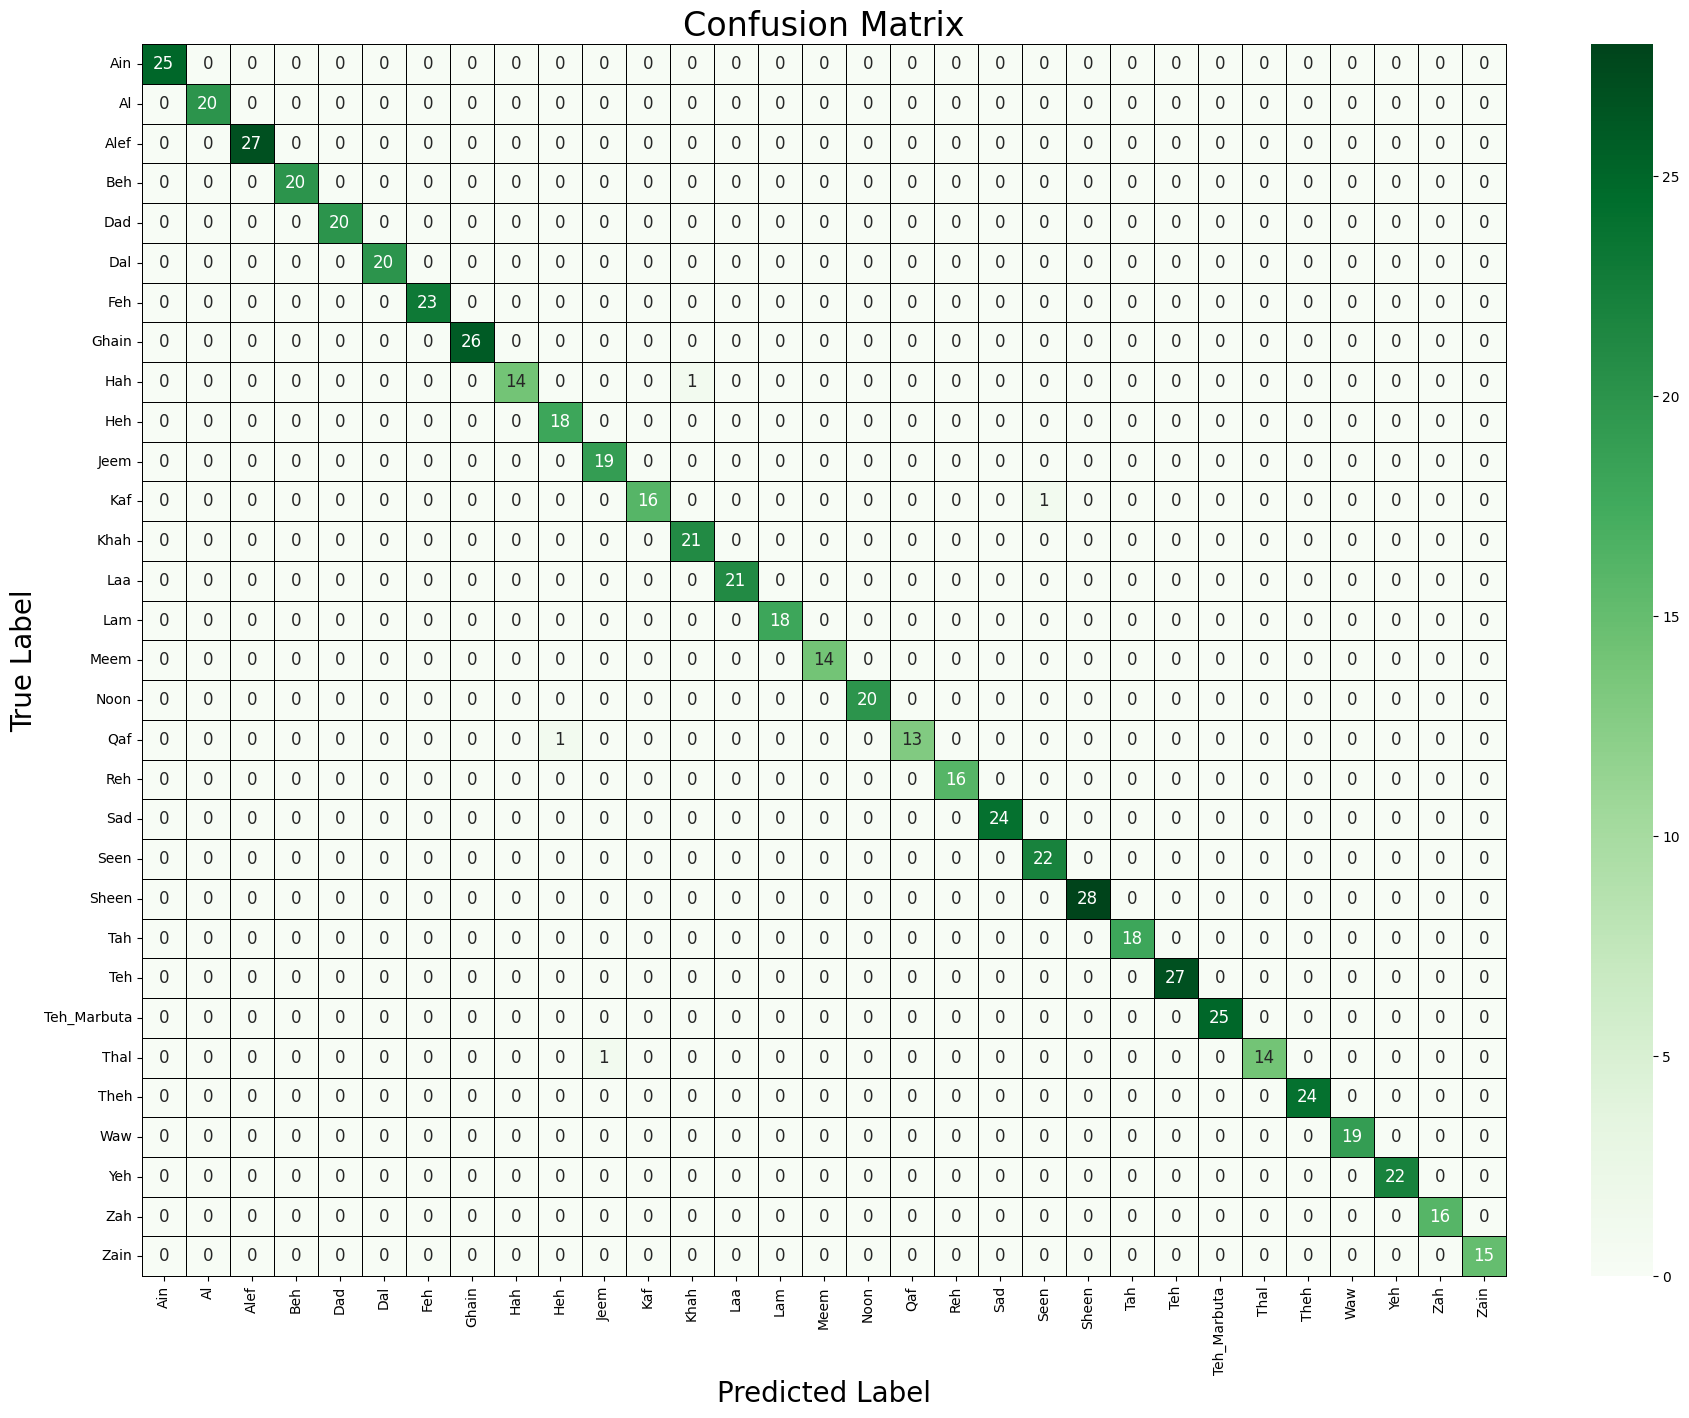

In [40]:
plot_confusion_matrix(
    test_labels, 
    test_preds, 
    figsize=(22, 16),  
    classes=test_ds.classes)

**Classification Report**

In [41]:
print(
    classification_report(
        test_labels, 
        test_preds, 
        target_names=test_ds.classes
    )
)

              precision    recall  f1-score   support

         Ain       1.00      1.00      1.00        25
          Al       1.00      1.00      1.00        20
        Alef       1.00      1.00      1.00        27
         Beh       1.00      1.00      1.00        20
         Dad       1.00      1.00      1.00        20
         Dal       1.00      1.00      1.00        20
         Feh       1.00      1.00      1.00        23
       Ghain       1.00      1.00      1.00        26
         Hah       1.00      0.93      0.97        15
         Heh       0.95      1.00      0.97        18
        Jeem       0.95      1.00      0.97        19
         Kaf       1.00      0.94      0.97        17
        Khah       0.95      1.00      0.98        21
         Laa       1.00      1.00      1.00        21
         Lam       1.00      1.00      1.00        18
        Meem       1.00      1.00      1.00        14
        Noon       1.00      1.00      1.00        20
         Qaf       1.00    

In [42]:
 report = classification_report(
        test_labels, 
        test_preds, 
        target_names=test_ds.classes,
        output_dict=True
    )

In [43]:
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report.to_csv('ResNet-KAN classification_report.csv', index=True)

In [44]:
def generate_performance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = accuracy_score(y_true, y_pred)
    top_3_accuracy = top_k_accuracy_score(
        y_true, y_probabilities, k=3
    )
    model_precision, model_recall, model_f1, _ = (
        precision_recall_fscore_support(
            y_true, y_pred, average="weighted"
        )
    )    
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')
    
    preformance_scores = {
        'accuracy_score'       : model_accuracy,
        'top_3_accuracy'       : top_3_accuracy,
        'precision_score'      : model_precision,
        'recall_score'         : model_recall,
        'f1_score'             : model_f1,
        'matthews_corrcoef'    : model_matthews_corrcoef
    }
    return preformance_scores

In [45]:
model_performance = generate_performance_scores(
    test_labels,
    test_preds, 
    test_probs
)


Performance Metrics:

accuracy_score:		0.9936

_____________________________________________
top_3_accuracy_score:	1.0000

_____________________________________________
precision_score:	0.9939

_____________________________________________
recall_score:		0.9936

_____________________________________________
f1_score:		0.9936

_____________________________________________
matthews_corrcoef:	0.9934



**ROC Score**

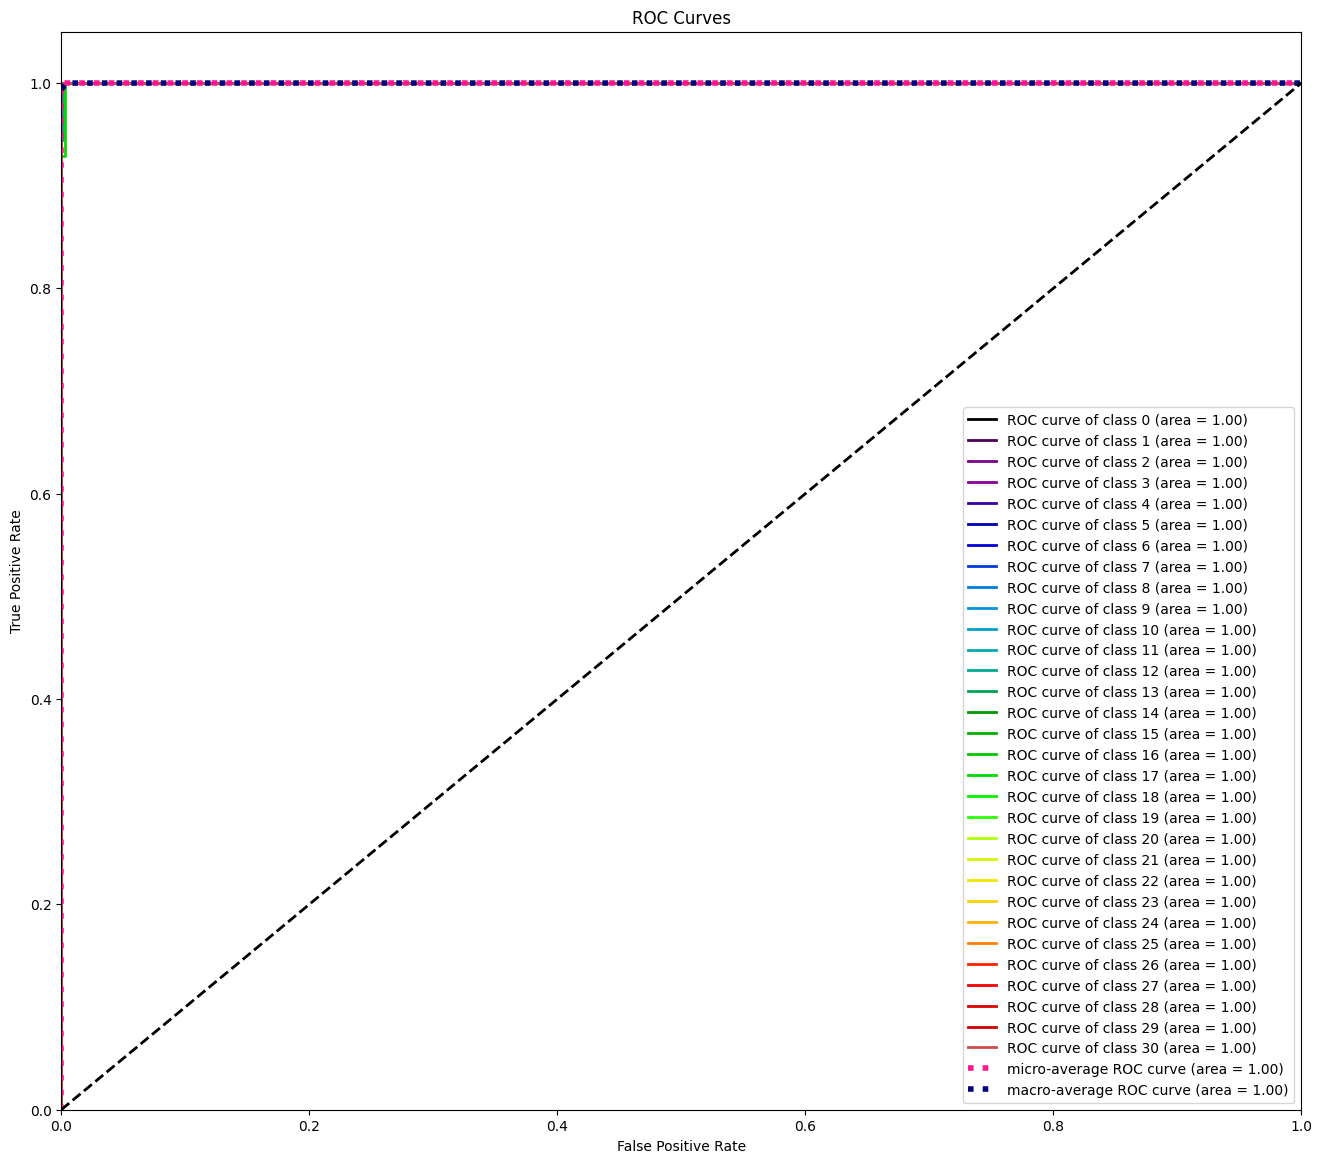

In [46]:
plot_roc(
    test_labels, 
    test_probs, 
    figsize=(16, 14), title_fontsize='large'
);

# **Performance Analysis**

**Probabilities and Predictions**

In [47]:
results_df = pd.DataFrame({
    'image_path'       : test_ds.paths,
    'label'            : test_ds.labels,
    'label_encoded'    : test_labels,
    'model_prediction' : test_preds,
    'model_probability': [test_probs[_][pred] for _, pred in zip(range(len(test_probs)), test_preds)]
})

pd.set_option('display.max_colwidth', None)
results_df

,image_path,label,label_encoded,model_prediction,model_probability
0,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Al/Al_14.jpg,Al,1,1,0.910277
1,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Jeem/Jeem_114.jpg,Jeem,10,10,0.902613
2,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Beh/Beh_32.jpeg,Beh,3,3,0.921746
3,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dad/Dad_209.jpg,Dad,4,4,0.934268
4,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Ghain/Ghain_57.jpeg,Ghain,7,7,0.909083
...,...,...,...,...,...
624,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Laa/Laa_211.jpg,Laa,13,13,0.897456
625,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Sheen/Sheen_255.jpg,Sheen,21,21,0.901327
626,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Teh_Marbuta/Teh_Marbuta_252.jpg,Teh_Marbuta,24,24,0.911202
627,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Heh/Heh_192.jpg,Heh,9,9,0.910302


In [48]:
import random

In [49]:
def view_multiple_predictions(df, classes, sample_loader, count=10, color_map='rgb', title=None, fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1
    
    idx = random.sample(df.index.to_list(), count)
    
    fig = plt.figure(figsize=fig_size)
    if title != None:
        fig.suptitle(title, fontsize=30)
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    # Setup useful dictionaries
    label_set = {k: v for k, v in enumerate(classes)}
    color_set = {False: 'red', True: 'darkgreen'}
    
    for column, _ in enumerate(idx):
        # Predict label
        img = sample_loader(df.image_path[_]).permute(1, 2, 0)
        
        # Validate prediction correctness
        correct_prediction = (df.model_prediction[_] == df.label_encoded[_])
        
        # Create subplot and assign title
        ax = plt.subplot(rows, 5, column+1)
        ax.set_title(
            f'Actual Label: {df.label[_]}', 
            pad=20, 
            fontsize=14,
            color=color_set[correct_prediction]
        )
        
        # Plot image
        if color_map=='rgb':
            ax.imshow(img)
        else:
            ax.imshow(img, cmap=color_map)
        
        # Plot prediction  & probability
        txt = f'Prediction: {label_set[df.model_prediction[_]]}\nProbability: {(100 * df.model_probability[_]):.2f}%'
        plt.xlabel(txt, fontsize=14, color=color_set[correct_prediction])
        
    return

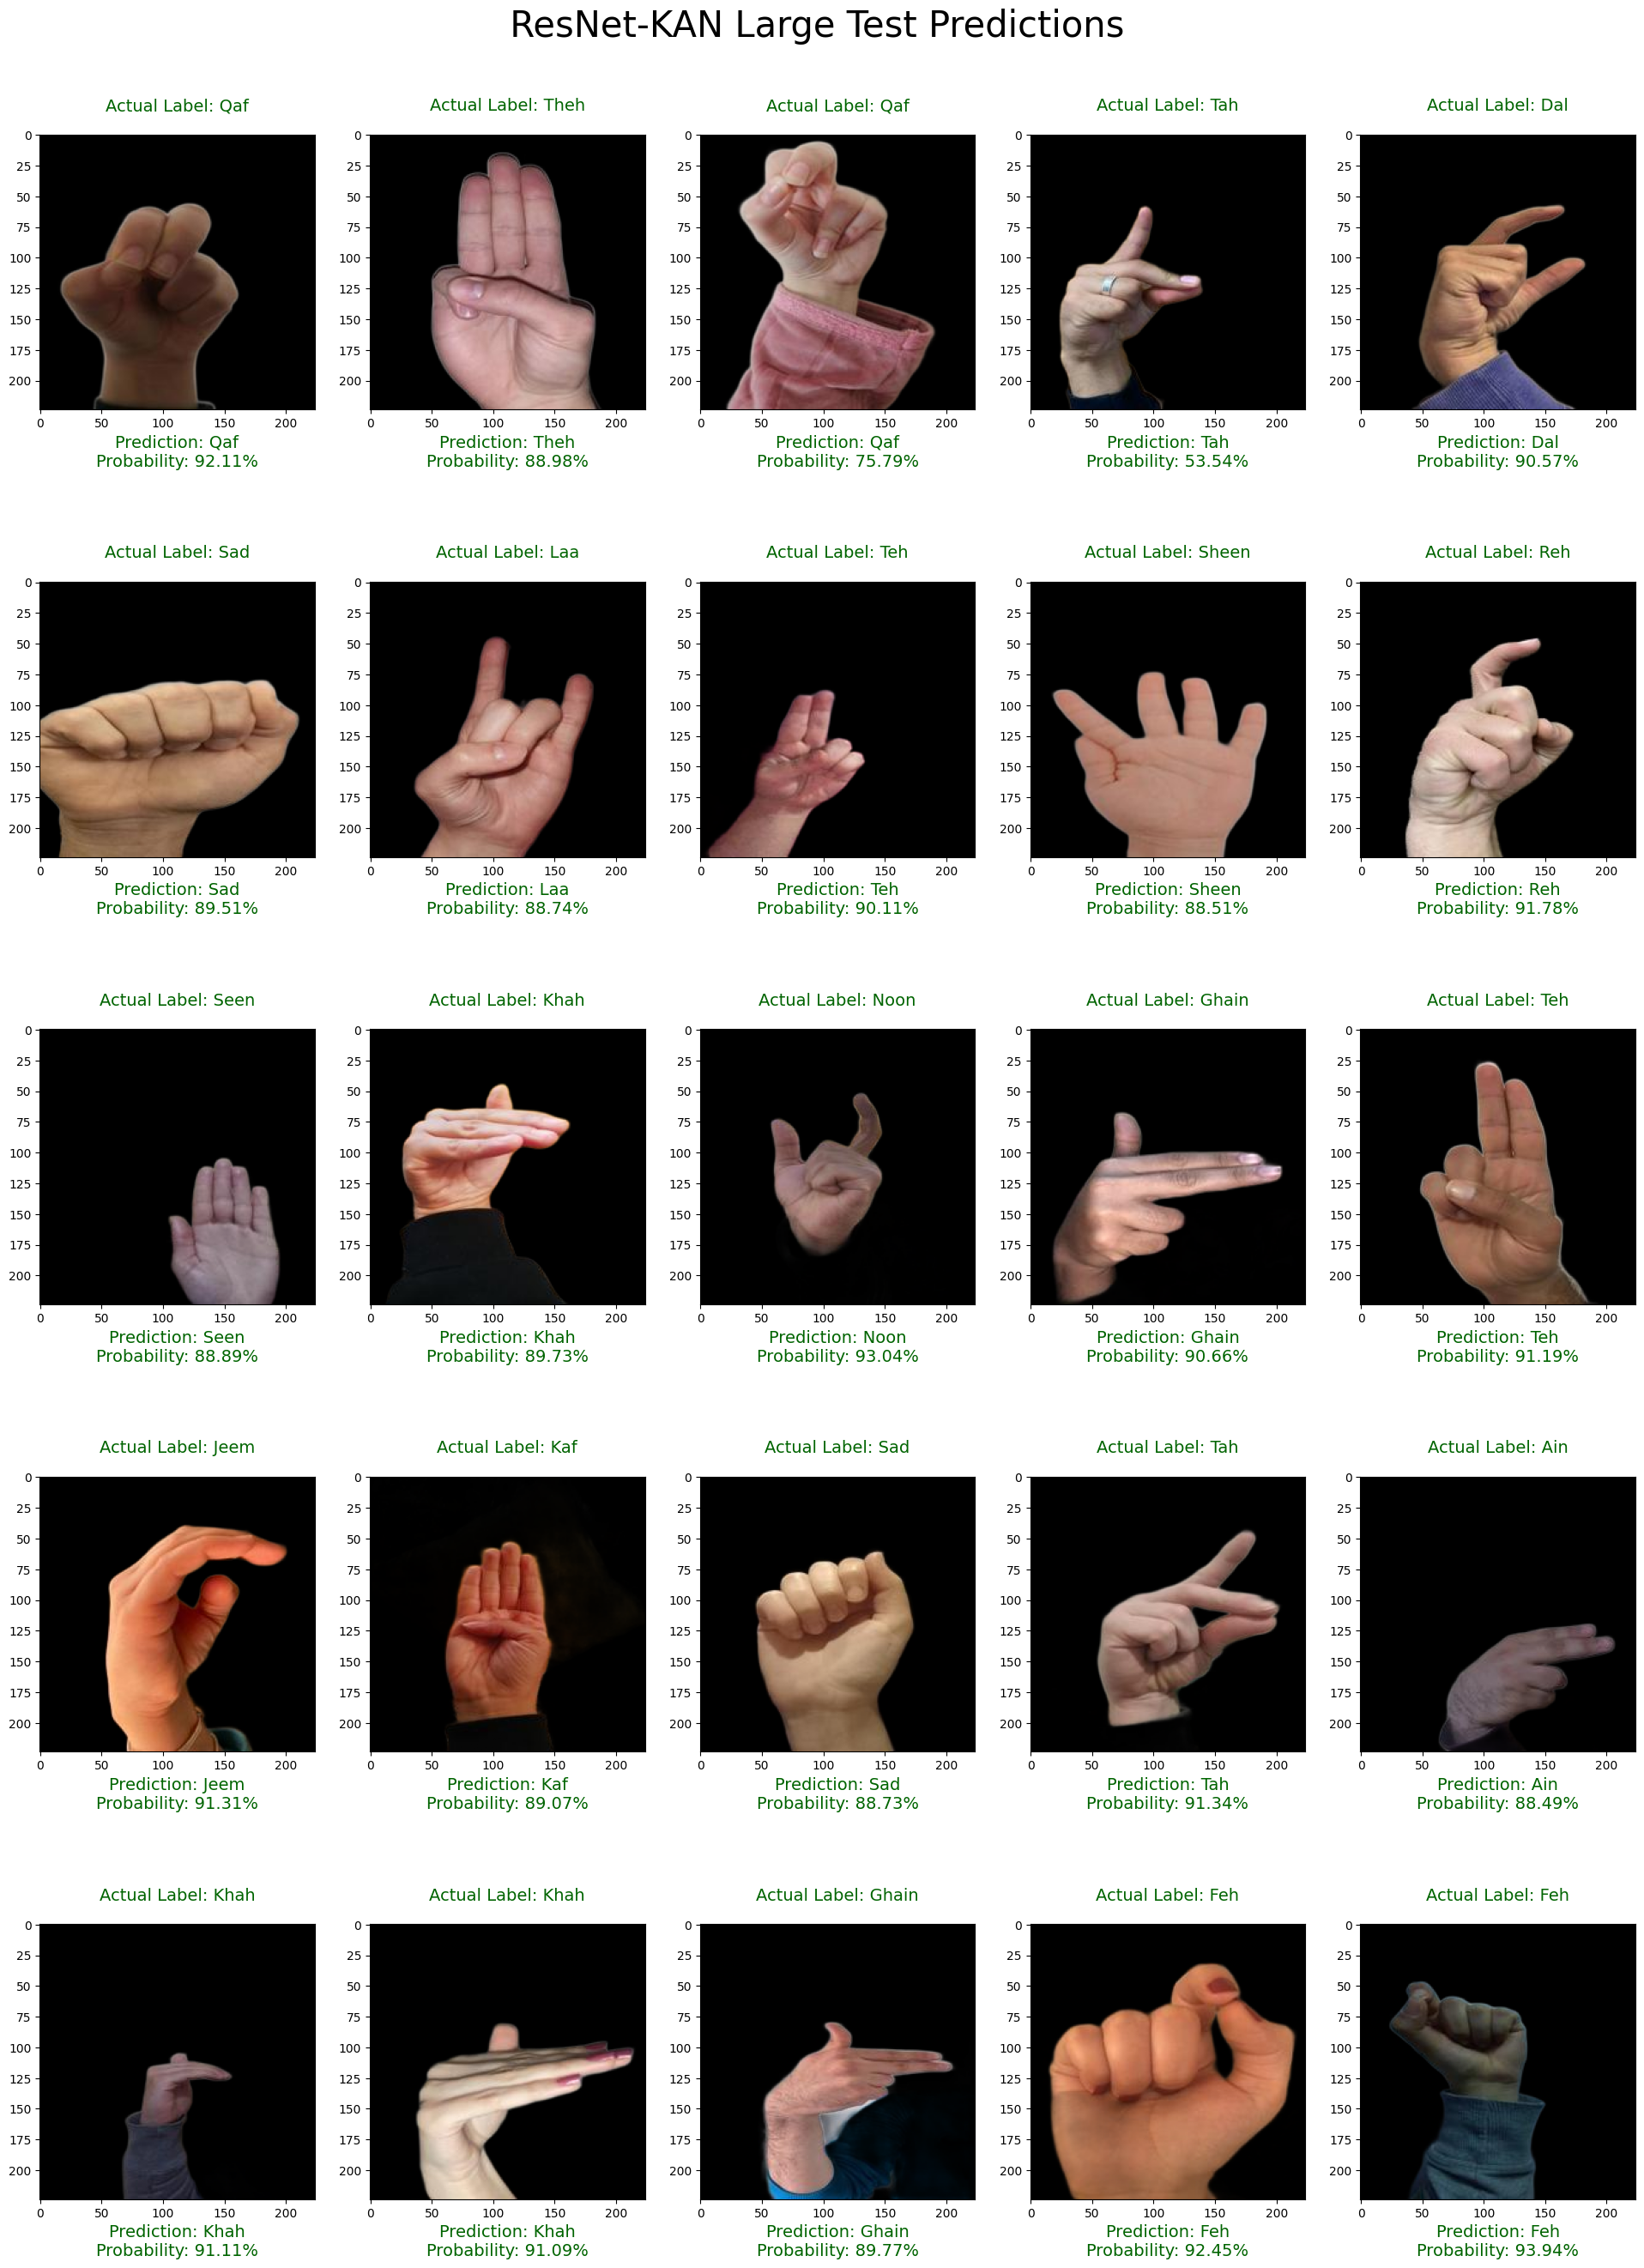

In [50]:
view_multiple_predictions(
    results_df,
    test_ds.classes,
    load, 
    count=25, 
    color_map='rgb', 
    title=' ResNet-KAN Large Test Predictions',
    fig_size=(24, 30)
)

**Incorrect Predictions**

In [51]:
# Query incorrect predictions
query_df = results_df[
    results_df['label_encoded'] != results_df['model_prediction']
].reset_index(drop=True)

# View incorrect predictions
query_df

,image_path,label,label_encoded,model_prediction,model_probability
0,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Qaf/Qaf_165.jpg,Qaf,17,9,0.761001
1,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Hah/Hah_137.jpg,Hah,8,12,0.453981
2,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Thal/thal_198.jpg,Thal,25,10,0.742260
3,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Kaf/Kaf_192.jpeg,Kaf,11,20,0.484570


In [52]:
# Save incorrect predictions info in csv file
query_df.to_csv('ResNet-KAN incorrect_predictions.csv', index=False)

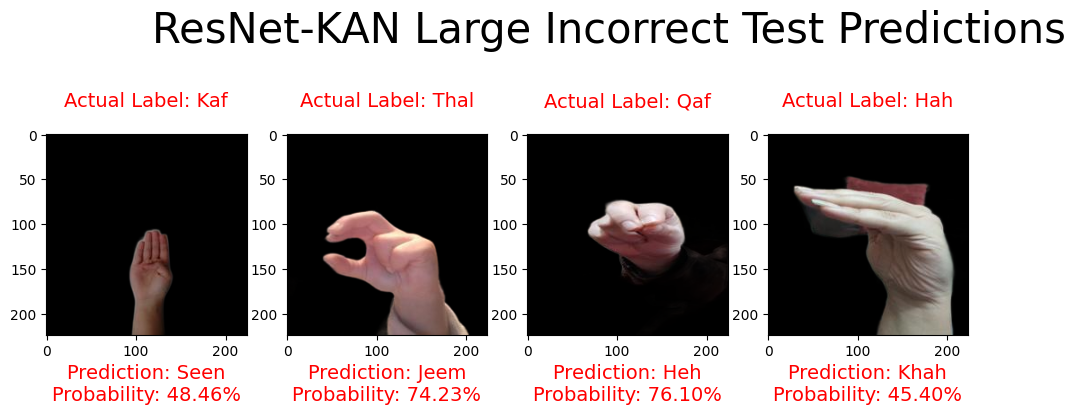

In [56]:
view_multiple_predictions(
    query_df,
    test_ds.classes,
    load, 
    count=4, 
    color_map='rgb', 
    title='ResNet-KAN Large Incorrect Test Predictions',
    fig_size=(15,5)
)

# **GradCAM**

In [57]:
#git clone
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-crjc7bzg
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-crjc7bzg
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit fd4b5c863fbfc06b23d2d396413e08831c2c2ecf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=41821 sha256=2ceb7b73903b828f6573504bbe852af6740e466fd4ad66525099dc4d9e250934
  Stored in directory: /tmp/pip-ephem-wheel-cache-xuyr_kqt/wheels/23/11/66/71a38b0c29ba4ec5f62105a2145278613855bc9c94eecf630d
Successfully built grad-cam


In [58]:
#imports
import copy
import torchvision
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [59]:
#target_layers = [model.layer4[-1]]
target_layers = [model.model.layer4[-1]]

In [60]:
pd.set_option('display.max_colwidth', None)
sorted_df = results_df.sort_values(by="model_probability", ascending=False)
sorted_df.head(20)
#sorted_df['image_path']

,image_path,label,label_encoded,model_prediction,model_probability
532,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Tah/Tah_68.jpg,Tah,22,22,0.959135
403,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Reh/Reh_210.jpeg,Reh,18,18,0.951078
194,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Feh/Feh_171.jpg,Feh,6,6,0.950592
460,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Reh/Reh_116.jpg,Reh,18,18,0.945411
402,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Thal/thal_50.jpg,Thal,25,25,0.942280
269,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Zain/Zain_148.jpg,Zain,30,30,0.941980
25,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dad/Dad_153.jpg,Dad,4,4,0.941792
230,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Tah/Tah_136.jpeg,Tah,22,22,0.941105
504,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Tah/Tah_99.jpg,Tah,22,22,0.939740
336,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Waw/Waw_49.jpg,Waw,27,27,0.939597


In [61]:
sorted_df.to_csv('ResNet-KAN sorted probability.csv', index=True)

In [75]:
paths = "/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Tah/Tah_136.jpeg"

rgb_img = Image.open(paths).convert('RGB')
# Max min normalization
rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
# Create an input tensor image for your model
input_tensor = torchvision.transforms.functional.to_tensor(rgb_img).unsqueeze(0).float()
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

grayscale_cam = cam(input_tensor=input_tensor)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

**GradCAM Visualization**

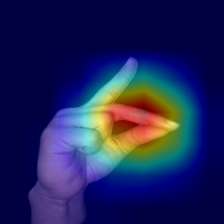

In [76]:
Image.fromarray(visualization, 'RGB')

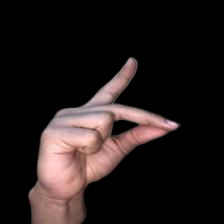

In [77]:
Image.open(paths).convert('RGB')